# Preliminaries

In [ ]:
# Import libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import SciPy statistical libraries
from scipy.stats import normaltest, shapiro, jarque_bera, boxcox
from scipy.stats.mstats import winsorize

# Install sklearn extra prior to importing KMedoids
!pip install scikit-learn-extra

# Import Sci-kit Learn libraries for unsupervised learning 
# and dimensionality reduction
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE # we probably won't use TSNE due to computation time
from sklearn import metrics

# Install UMAP
!pip install umap-learn
import umap

In [ ]:
# Read in the data 
water = pd.read_csv("/content/drive/MyDrive/Drinking_water.csv")

# Exploratory Data Analysis

In [ ]:
# Obtain basic information about the dataset
water.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       3276 non-null   int64  
 1   ph               2785 non-null   float64
 2   Hardness         3276 non-null   float64
 3   Solids           3276 non-null   float64
 4   Chloramines      3276 non-null   float64
 5   Sulfate          2495 non-null   float64
 6   Conductivity     3276 non-null   float64
 7   Organic_carbon   3276 non-null   float64
 8   Trihalomethanes  3114 non-null   float64
 9   Turbidity        3276 non-null   float64
 10  Potability       3276 non-null   int64  
 11  Carcinogenics    0 non-null      float64
 12  medical_waste    0 non-null      float64
dtypes: float64(11), int64(2)
memory usage: 332.8 KB


This dataset is composed of 13 features and 3276 entries/rows. All features exhibit numerical data that is either a floating decimal or an integer, in the case of the target variable. We must note that there are some variables with missing entries, namely: `ph`, `Sulfate`, and `Trihalomethanes`, while there are no entries for the features `Carcinogenics` and `medical_waste`. For the latter two features, we will drop them from the dataset along with `Unnamed: 0`, which appears to just be an index column.

In [ ]:
# Drop empty features from dataset
water = water.drop(['Unnamed: 0', 'Carcinogenics', 'medical_waste'], axis= 1)

# Obtain descriptive statistics for all columns save for the target variable
water.drop('Potability', axis= 1).describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000


It seems that every variable exhibits some extreme values that require our attention, in addition to the missing entries. We will now plot the distributions for the features. 

*Note that range for the `ph` variable is 0 to 14, which is theoretically sensible, however the likelihood of encountering water with pH values this extreme seems immensely unlikely. As such, we will  winsorize the `ph` variable to mitigate these extreme values.

Furthermore, there is a massive difference between the $75^{\text{th}}$ percentile and maximum value for the variable `Solids`, which indicates that this feature requires much more attention.

In [ ]:
# Output the number of distinct values for each feature

for col in water.columns:

    print("Number of distinct values in {}: {}".format(col, water[col].nunique()))

Number of distinct values in Hardness: 3276
Number of distinct values in Chloramines: 3276
Number of distinct values in Sulfate: 2496
Number of distinct values in Organic_carbon: 3276
Number of distinct values in Trihalomethanes: 3115
Number of distinct values in Turbidity: 3276
Number of distinct values in Potability: 2
Number of distinct values in wins_pH: 2590
Number of distinct values in Sqrt_Solids: 3276
Number of distinct values in Boxcox_Conductivity: 3276


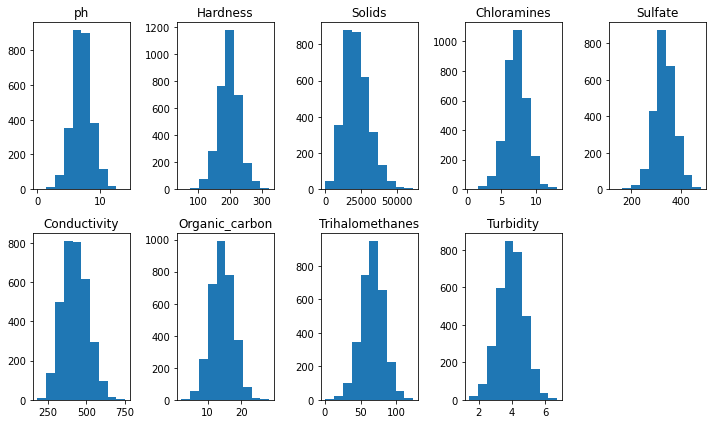

In [ ]:
# Plot histograms for each of the features 
plt.figure(figsize= (10,6))
c = 1

for col in water.drop('Potability', axis= 1):

    plt.subplot(2,5,c)
    plt.hist(water[col])
    plt.title("{}".format(col))
    c += 1

plt.tight_layout()
plt.show()

Most of the features seem fairly close to being normally distributed, exhibiting some skew or kurtosis, although we can formally check for these. Firstly, we will impute missing values with the mean for each column, so as to not significantly alter the distribution.

In [ ]:
# Impute missing values
missing_var_list = ['ph', 'Sulfate', 'Trihalomethanes']

for var in missing_var_list:

    water.loc[:, var] = water.loc[:, var].fillna(water[var].mean())

In [ ]:
# Perform formal checks for normality
for col in water.drop('Potability', axis= 1):
    
    if (normaltest(water[col])[1] < 0.05) and (shapiro(water[col])[1] < 0.05):
        print("Able to reject the Null for {}".format(col))
    if (normaltest(water[col])[1] > 0.05) and (shapiro(water[col])[1] > 0.05):
        print("Unable to reject the Null for {}".format(col))

Able to reject the Null for ph
Able to reject the Null for Hardness
Able to reject the Null for Solids
Able to reject the Null for Chloramines
Able to reject the Null for Sulfate
Able to reject the Null for Conductivity
Unable to reject the Null for Organic_carbon
Able to reject the Null for Trihalomethanes
Unable to reject the Null for Turbidity


The Null hypothesis for these tests is that the sample was drawn from a normal distribution. For all but the `Organic_carbon` and `Turbidity`, we are able to reject the Null hypothesis, indicating that we may need to apply transformations to the features. 

Given that most domains of the features are strictly positive, except for `pH`, to which we can only apply a square-root transformation or winsorization, we can apply the boxcox transformation and apply a Jarque-Bera test to determine if the transformation yielded a distribution that more normally distributed.

We will first visually check for extreme values via boxplot. Then, we will apply two-way winsorization to `ph`, as it will address the extreme values on both tails of the distribution.

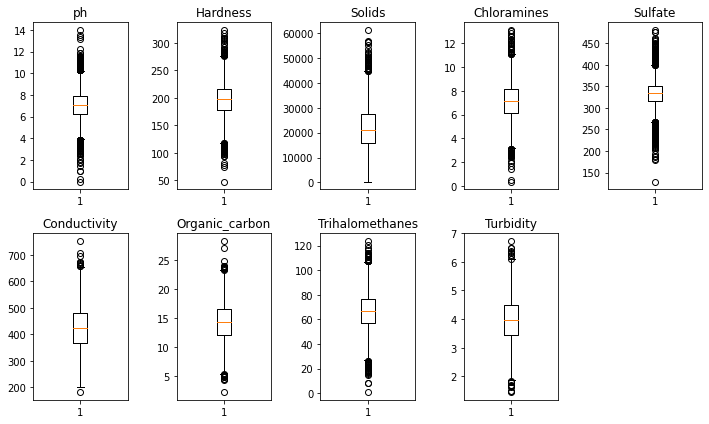

In [ ]:
# Plot boxplots for each of the features 
plt.figure(figsize= (10,6))
c = 1

for col in water.drop('Potability', axis= 1):

    plt.subplot(2,5,c)
    plt.boxplot(water[col])
    plt.title("{}".format(col))
    c += 1

plt.tight_layout()
plt.show()

In [ ]:
# Iterate through a list from 0 to 0.1 in increments of 0.01
nums = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]

# Define a copy of the dataset
water_copy = water.copy()

for num in nums:
   water_copy['wins_pH: ({}, {})'.format(int(100*num), int(100*(1-num)))] = winsorize(water['ph'], [num, num])

Text(0.5, 1.0, 'Winsorization Treatments')

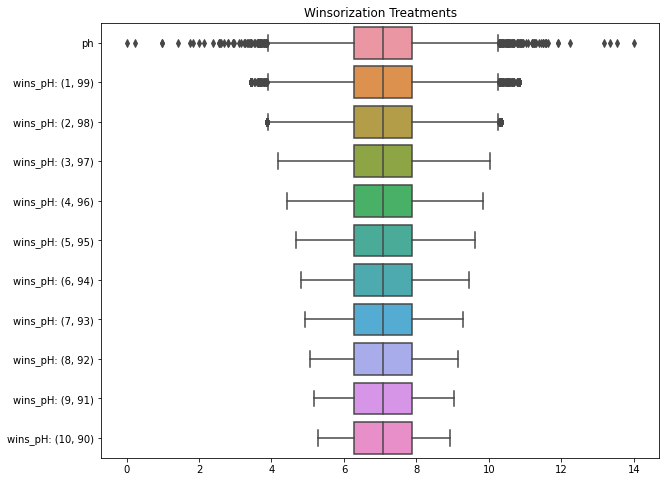

In [ ]:
# Visualize boxplots of the original and winsorized treatments
treatments = ['ph', 'wins_pH: (1, 99)', 'wins_pH: (2, 98)', 'wins_pH: (3, 97)',
              'wins_pH: (4, 96)', 'wins_pH: (5, 95)', 'wins_pH: (6, 94)',
              'wins_pH: (7, 93)', 'wins_pH: (8, 92)', 'wins_pH: (9, 91)',
              'wins_pH: (10, 90)']

plt.figure(figsize=(10, 8))
ax = sns.boxplot(data= water_copy[treatments], orient= "h", )
plt.title("Winsorization Treatments")

Based on the above graphic, it appears that winsorization of the feature `ph` to the $3^{\text{rd}}$ and $95^{\text{th}}$ percentiles both adequately addresses outliers (without eliminating them) while retaining the most information. Now, we will need to proceed to examining the other variables.

In [ ]:
# Apply square-root, logarithmic, and boxcox transformations to the remaining variables,
# performing the Jarque-Bera test

def jb_test(X):
    pval_jb = jarque_bera(X)[1]
    if (pval_jb > 0.05):
       print("Unable to reject the null")

# Perform the test for the above transformations, for each variable

for col in water.drop(['Potability', 'ph'], axis= 1):
    
    OG = water_copy[col]
    Sq = np.sqrt(water_copy[col])
    Log = np.log(water_copy[col])
    boxcoxx,_ = boxcox(water_copy[col]) 
    transforms = [Sq, Log, boxcoxx]

    print("Feature: {}".format(col))
    
    for i,transform in enumerate(transforms):
        print(i)
        jb_test(transform)

Feature: Hardness
0
1
2
Feature: Solids
0
Unable to reject the null
1
2
Unable to reject the null
Feature: Chloramines
0
1
2
Feature: Sulfate
0
1
2
Feature: Conductivity
0
1
2
Feature: Organic_carbon
0
1
2
Unable to reject the null
Feature: Trihalomethanes
0
1
2
Feature: Turbidity
0
1
2
Unable to reject the null


It seems that for every feature, save for `Solids`, `Organic_carbon`, and `Turbidity`, no transformation method yielded a normally distributed variable. At this point, rather than seek normality, all we can strive for is the mitigation of extreme values 

In [ ]:
# Plot boxplots for each transformation method and feature

import plotly.graph_objects as go
plt.figure(figsize= (10,8))
c = 1

for feature in water.drop(['Potability', 'ph'], axis= 1):

    # define the boxcox transformation for each feature
    boxcoxx,_ = boxcox(water_copy[feature])
    
    # Initialize each plot
    fig = go.Figure()
    fig.add_trace(go.Box(y= water_copy[feature], name= 'Original', 
                         boxpoints= 'suspectedoutliers', marker= dict( 
                         color= 'rgb(8, 81, 156)',
                         outliercolor= 'rgba(219, 64, 82, 0.6)')))   
    fig.add_trace(go.Box(y= np.sqrt(water_copy[feature]), name= 'Square Root', 
                         boxpoints= 'suspectedoutliers', marker= dict(
                         color= 'rgb(8, 81, 156)',
                         outliercolor= 'rgba(219, 64, 82, 0.6)')))
    fig.add_trace(go.Box(y= np.log(water_copy[feature]), name= 'Logarithmic', 
                         boxpoints= 'suspectedoutliers', marker= dict(
                         color= 'rgb(8, 81, 156)', 
                         outliercolor= 'rgba(219, 64, 82, 0.6)')))
    fig.add_trace(go.Box(y= boxcoxx, name= 'Boxcox', 
                         boxpoints= 'suspectedoutliers', marker= dict(
                         color= 'rgb(8, 81, 156)', 
                         outliercolor= 'rgba(219, 64, 82, 0.6)')))
    
    fig.update_layout(title_text= "Transformations for {}".format(feature))
    fig.show()

    c = c + 1

<Figure size 720x576 with 0 Axes>

Based upon the above graphics, we can proceed with the original, untreated, version of most of the features, with the following exceptions and their corresponding treatments:

1. `Solids` - Square Root
2. `Conductivity` - Square Root or Boxcox

Aside from these transformations, there is still the potential dilemma posed by extreme values, especially for the feature `Solids`. As we are unable to ascertain whether these are clerical or measurement errors, or whether they are actual measurements, we either need to apply winsorization to each feature to reduce the potential impact of extreme values on clustering algorithms, or we will have to consider only using clustering algorithms that are less sensitive to the presence of outliers, such as DBSCAN and k-mediods, in tandem with Sci-kit Learn's RobustScaler method. Of the two approaches, the latter is less ethically questionable and more justifiable. 

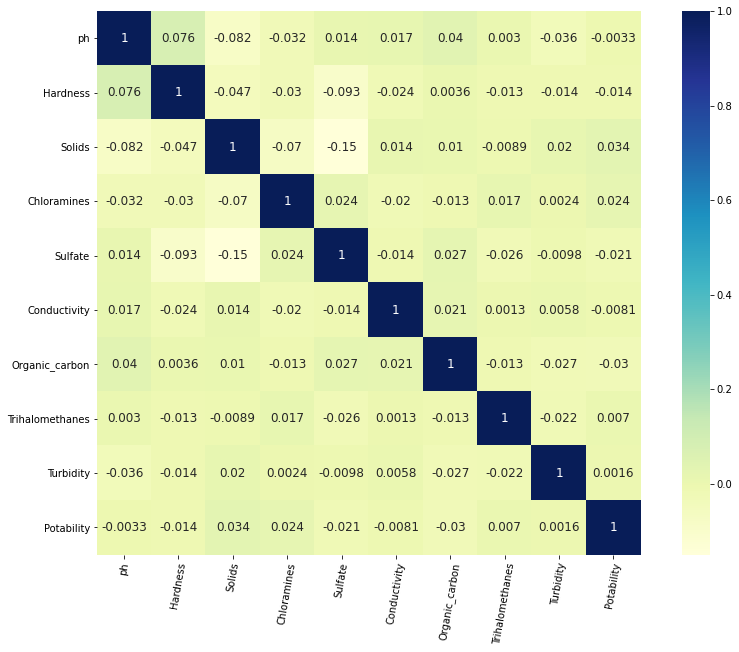

In [ ]:
# Compute and display a correlation matrix
corrs = water.corr()

f, ax = plt.subplots(figsize=(15,10))
heatmap = sns.heatmap(corrs, square = True,
                    cmap = 'YlGnBu', annot = True,
                    annot_kws = {"size": 12})

# Add column names as labels
ax.set_yticklabels(corrs.columns, rotation = 0)
ax.set_xticklabels(corrs.columns, rotation = 80)            

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

It seems that the target variable `Potability` isn't strongly correlated with any of the features.

# Feature Engineering

In [ ]:
# Apply transformations and winsorization treatments to original dataframe

# Apply two-way winsorization to the variable `ph`
water['wins_pH'] = winsorize(water['ph'], [0.03, 0.03])

# Apply transformations to other features
water['Sqrt_Solids'] = np.sqrt(water['Solids'])
water['Boxcox_Conductivity'] = boxcox(water['Conductivity'])[0]

# Drop the original versions of the treated features
water = water.drop(['ph', 'Solids', 'Conductivity'], axis= 1)

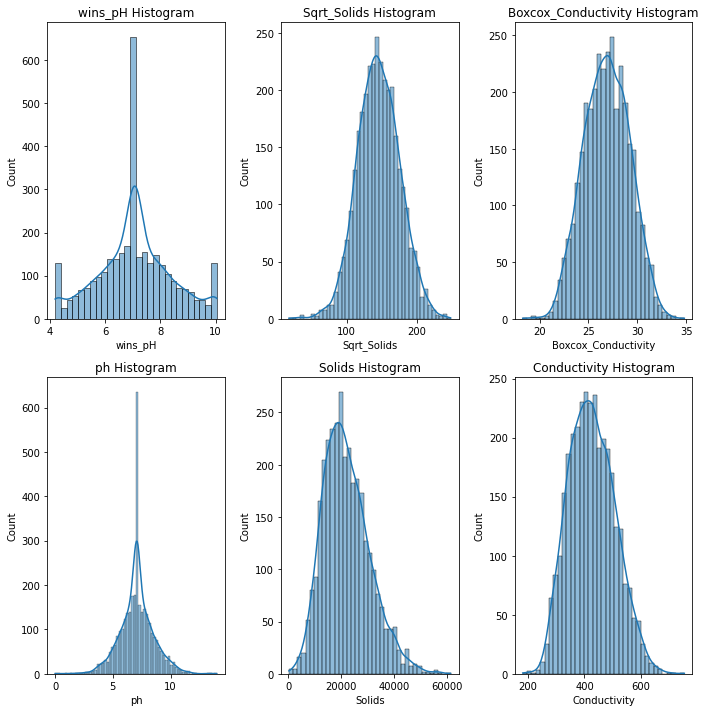

In [ ]:
# Display histograms for the transformations

# Define a list with original forms of the features as entries
og_features = ['ph', 'Solids', 'Conductivity']

# Define a list with the transformed or treated features as entries
new_features = ['wins_pH', 'Sqrt_Solids', 'Boxcox_Conductivity']

# Initialize a global variable for iteration loop purposes while
# setting figure sizes
plt.figure(figsize=(10,10))
c = 1

for i, feature in enumerate(new_features):

    plt.subplot(2,3,c)
    sns.histplot(data = water[feature], kde = True, legend = True)
    plt.title("{} Histogram".format(feature))

    plt.subplot(2,3,c + 3)
    sns.histplot(data = water_copy[og_features[i]], kde = True, legend = True)
    plt.title("{} Histogram".format(og_features[i]))
    
    c += 1 # Update the global variable c

plt.tight_layout()
plt.show()

Visually, the treatments applied to the `Solids` and `Conductivity` variables yielded two-tailed distributions that were seemingly normal, albeit with either some skew or kurtosis. For the variable `ph` however, due to the perplexing nature of extreme values within the data, expecting to obtain a normal distribution after winsorization seemed unrealistic.

Now that we have cleaned the data and applyed transformations where necessary, we can proceed to preprocessing in preparation for our clustering algorithms, most specifically, DBSCAN and k-mediods.

# Data Preprocessing and Visualization

In [ ]:
# Define the features
X = water.drop('Potability', axis= 1)
y = water['Potability']

# Standardize the scaling of the feature set
scaler = RobustScaler()
X_rs = scaler.fit_transform(X)

In [ ]:
# Define a visualization function
def visualizer(A):

    plt.figure(figsize=(10,5))
    plt.scatter(A[:, 0], A[:, 1])
    plt.title("Dimensionality Reduction Results")
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

In [ ]:
# Apply UMAP to visualize the dataset
import time as time
import warnings
warnings.filterwarnings('ignore')

time_begin = time.time()

# Initiate UMAP and train it on the dataset
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_rs)

print("UMAP finished. Time elapsed: {} seconds".format(time.time() - time_begin))

UMAP finished. Time elapsed: 23.462765216827393 seconds


In [ ]:
# Output the shape of the embedding
embedding.shape

(3276, 2)

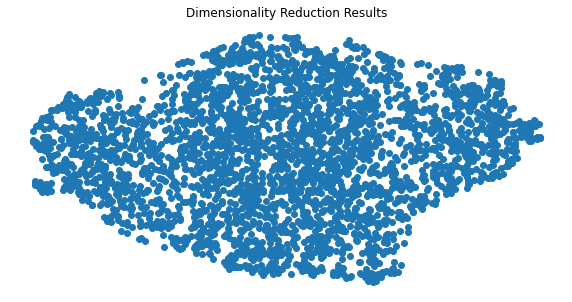

In [ ]:
# Visualize the dataset with UMAP

visualizer(embedding)

Hmmm, this isn't too revealing of a visualization in that there aren't distinguishable clusters. We'll try PCA

In [ ]:
# Apply PCA to the dataset
time_start = time.time()

pca = PCA(n_components= 2)
components = pca.fit_transform(X_rs)

print("PCA complete. Time elapsed: {}".format(time.time() - time_start))

PCA complete. Time elapsed: 0.02031397819519043


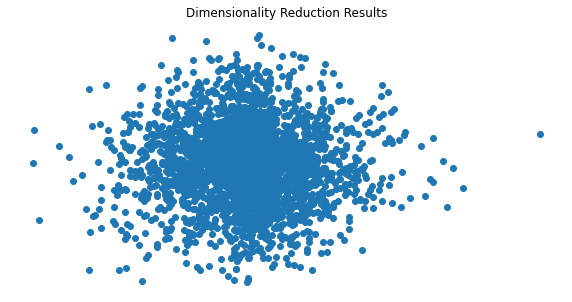

In [ ]:
# Visualize the PCA results
visualizer(components)

It seems that this is slightly worse than UMAP. Going forward, we'll utilize UMAP for visualization.

# Clustering Algorithms

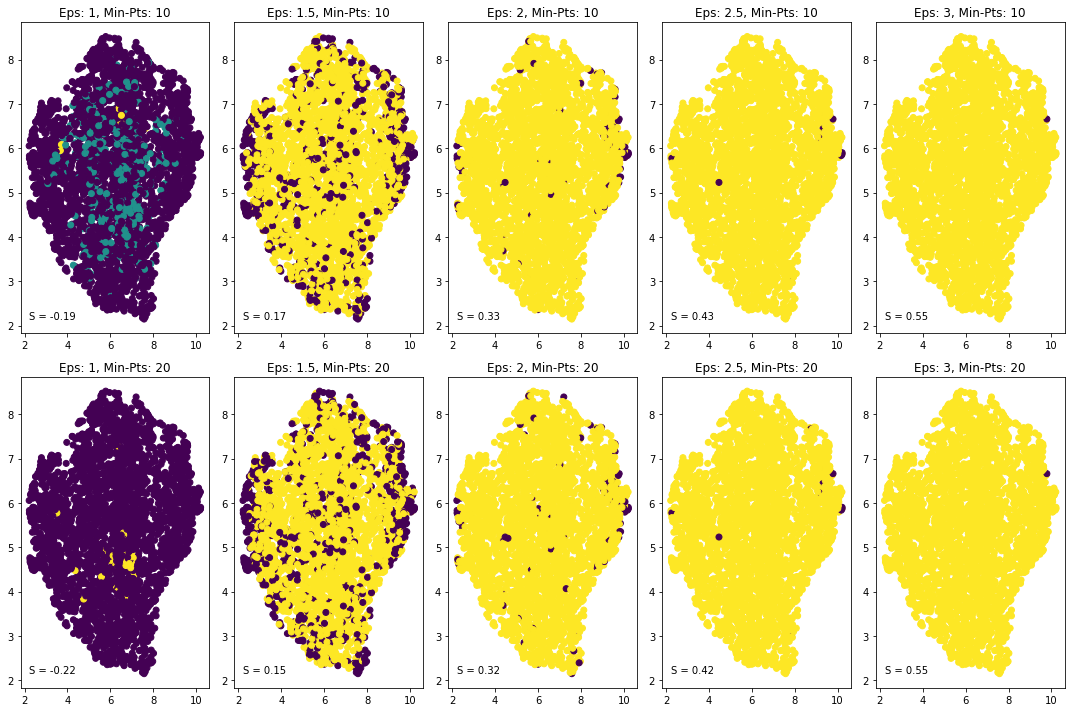

DBSCAN complete. Time elapsed: 8.190271377563477 seconds


In [ ]:
# Build DBSCAN models for various epsilon and min_samples values
time_start = time.time()
plt.figure(figsize= (15,10))
C = 1

# Epsilon and min_samples lists
epsilons = [1, 1.5, 2, 2.5, 3]
Min_pts = [10, 20]

# Iterate over the above two lists while applying DBSCAN to the dataset

for min_pts in Min_pts:

    for epsilon in epsilons:

        dbscan = DBSCAN(eps= epsilon, min_samples= min_pts, metric= 'euclidean')

        # Fit the model while computing the silhouette score
        clusters = dbscan.fit_predict(X_rs)
        S = metrics.silhouette_score(X_rs, clusters, metric= 'euclidean')

        # Visualize the results with UMAP for dimensionality reduction
        plt.subplot(2,5,C)
        plt.scatter(embedding[:, 0], embedding[:, 1], c= clusters)
        plt.title("Eps: {}, Min-Pts: {}".format(epsilon, min_pts))
        plt.text(embedding[:, 0].min(), embedding[:, 1].min(), "S = {:0.2f}".format(S))
        C = C + 1

plt.tight_layout()
plt.show()

print("DBSCAN complete. Time elapsed: {} seconds".format(time.time() - time_start))

Curious. As $\epsilon$ required to form a cluster increases, so too does the silhouette score. This makes sense in that increasing $\epsilon$ increases the neighborhood of similarity for a given point when computing the silhouette score. On another note, there are no linearly separable or distinguishable clusters here. We will proceed to k-mediod as our final method here.

In [ ]:
# Import KMedoids
from sklearn_extra.cluster import KMedoids

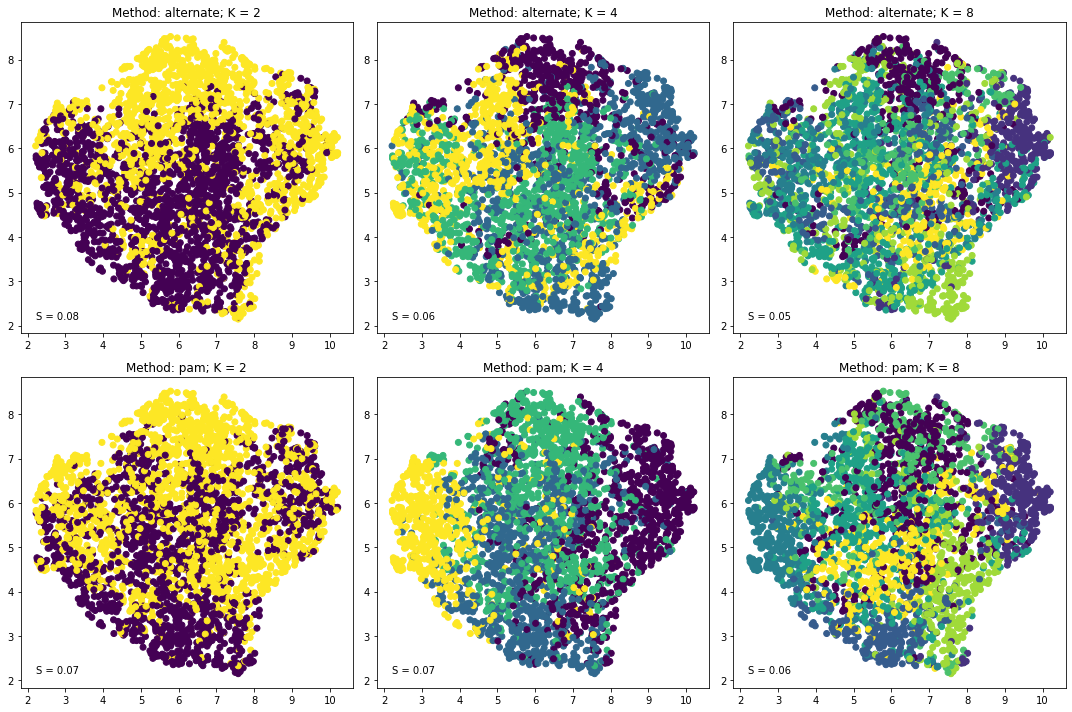

K-Medoids complete. Time elapsed: 14.815731525421143 seconds


In [ ]:
# Instantiate and build some KMedoids clustering algorithms
time_start = time.time()
plt.figure(figsize= (15,10))
C = 1

# List of potential number of cluster numbers and methods
K = [2, 4, 8]
methods = ['alternate', 'pam']

# Iterate over the above two lists

for method in methods:

    for value in K:

        kmedoids = KMedoids(n_clusters= value, method= method, random_state= 333)

        # Fit the algorithm and compute a silhouette score
        k_clusters = kmedoids.fit_predict(X_rs)
        S = metrics.silhouette_score(X_rs, k_clusters, metric= 'euclidean')

        # Visualize the clustering results using UMAP for dimensionality reduction
        plt.subplot(2,3,C)
        plt.scatter(embedding[:, 0], embedding[:, 1], c= k_clusters)
        plt.title("Method: {}; K = {}".format(method, value))
        plt.text(embedding[:, 0].min(), embedding[:, 1].min(), "S = {:0.2f}".format(S))
        
        C += 1

plt.tight_layout()
plt.show()

print("K-Medoids complete. Time elapsed: {} seconds".format(time.time() - time_start))

This is interesting for two reasons. Firstly, for each value of `n_clusters` and method (either alternate or pam), K-Medoid seems to have performed worse than DBSCAN, based upon the silhouette score. Secondly, similar to DBSCAN, there aren't any linearly separable clusters identifyed by K-Medoids, albeit for a projection into two-dimensional space. One could once again train the above two models, but visualize them in three dimensions.

# Data Visualization with UMAP: $3\text{D}$ 

We'll Plotly for visualizing the dataset in three dimensions, prior to applying any clustering algorithms again.

In [ ]:
# Define a 3-dimensional visualizer function
def three_dim(A):

    plt.figure(figsize=(10,5))
    plt.scatter(A[:, 0], A[:, 1], A[:, 2])
    plt.title("Dimensionality Reduction Results")
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

In [ ]:
# Apply UMAP to the dataset
time_start = time.time()

reducer_3d = umap.UMAP(n_neighbors= 20, n_components= 3, densmap= True)
embedding_3d = reducer_3d.fit_transform(X_rs)

print("UMAP finished. Time elapsed: {} seconds".format(time.time() - time_begin))

UMAP finished. Time elapsed: 6628.393976449966 seconds


In [ ]:
# Visualize the results
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

fig = go.Figure(data= go.Scatter3d(x= embedding_3d[:, 0], 
                                   y= embedding_3d[:, 1],
                                   z= embedding_3d[:, 2],
                                   mode= 'markers'))
fig.show()

This seems to indicate that the data doesn't exhibit any linearly separable clusters within it.